# Example 5: HA model with flexible prices and FTPL tax rule

In this notebook we 

- 1. solve a modified version of the one-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)) For model details please see their paper

     Modifications:
      
         - Flexible Prices
    
         - Endowment Economy

         - Government Bonds are Nominal

         - Fiscal Policy follows a passive/active FTPL tax rule
    
- 2. Using the Jacobian from step 1 to compute the winding number to check determinacy following Hagedorn (2023) "Local Determinacy in Incomplete-Markets Models"

For more examples and information on the Local Determimnacy toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import local_determinacy as ld

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules


## 2 The Model

We follow Auclert, Bardóczy, Rognlie, Straub (2021) and define

- Inputs for the heterogeneous household block 

- Other model (non-household) parts (steady state)

- Compute and Calibrate the Steady state

- Other model (non-household) parts (transition)

### 2.1 Hetinputs

We use the hetBlock`hh_sim` (standard incomplete markets model) from the SSJ toolkit located in `sequence_jacobian/hetblocks`.


In [2]:
hh = hetblocks.hh_sim.hh

def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
            e_grid, pi_e , Pi = grids.markov_rouwenhorst(rho_e, sd_e, n_e)
            a_grid = grids.asset_grid(min_a, max_a, n_a)
            return e_grid, pi_e, Pi, a_grid

def income(w, Tax, pi_e, e_grid):
            tax_rule = e_grid
            tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
            #tax = Tax
            y = w * e_grid - tax 
            return y

hh1 = hh.add_hetinputs([make_grids, income])


### 2.2 Model Blocks 

We substitute lagged values to simplify the comuputation of the winding number.
Lagged Inflation pi(-1) -> piL

$\underline{\text{Monetary policy rule}}$ for nominal interest rate $i_{t+1}$
$$
\frac{1+i_{t+1}}{1+r^*} = 1 +\phi  \frac{P(-1)-P_{ss}}{P_{ss}} = 1 +\phi  \frac{PL-P_{ss}}{P_{ss}},
$$
where $PL$ is the lagged price level, $P_{ss}$ is the steady-state price level and $r^*$ is the steady-state interest rate.

$\underline{\text{FTPL tax rule}}$ 
$$
\tau_t = \tau_{ss} + \gamma (r_t b_t - \tau_{ss}),
$$
where $\tau_{ss}$ is steady-state taxes, $b_t$ is real bonds, $r_t$ is the real interest rate and $\gamma \geq 0$ desscribes the tax response to interest rate payments.

- $\gamma \in (0,1):$  active fiscal policy (Leeper, 1991)

- $\gamma > 1:$  passive fiscal policy (Leeper, 1991)


In [3]:
@simple
def monetary(piL, rstar, rscale, phi):
        rN = (1 + rstar + rscale* phi * piL) -1 
        return rN

@simple
def monetaryReal(piL, rN, Realshock):
        r = (1 + rN) / (1 + piL(+1)) - 1  + Realshock
        return r


@simple
def fiscal(rN, B, piL, tss, gamma):
        Tax = tss  + gamma*(((1 + rN) / (1 + piL(+1)) - 1 ) * B - tss)  
        return Tax

@simple
def debt(rN, piL, B, Tax,Bss):
        budget = (-B(+1) + (((1 + rN) / (1 + piL(+1))) * B  -  Tax )   )/Bss 
        return budget

@simple 
def mkt_clearing(A, B,Bss):
        asset_mkt = (A - B(+1))/Bss
        bonds = B
        return asset_mkt, bonds


@simple
def nkpc_ss(mu):
        w = 1/mu
        return w

### 2.3 Steady State and Calibration



In [4]:

blocks_ss = [hh1,monetary, monetaryReal, fiscal, debt, mkt_clearing, nkpc_ss]

ha_ss = create_model(blocks_ss, name="One-Asset Simple HANK SS")

calibration =  {'eis': 1, 'rho_e': 0.945,  'sd_e': 0.7, 'n_e': 13,
               'min_a': 0.0, 'max_a': 1000, 'n_a': 200, 'Y': 1,  'Yss': 1,  'Bss': 4, 'tss': 0.05,   'piL': 0.0,
               'mu': 1.1, 'rstar': 0.0125, 'rscale': 1.0125 , 'Realshock': 0.0,  'phi': 1.1, 'gamma': 1.1, 'B': 4}

unknowns_ss = {'beta': 0.986}
targets_ss = {'asset_mkt': 0}


ss0 = ha_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")


### 2.4 Transition

- No further blocks need to be added: All steady-state blocks are valid in transition since prices are flexible. 

In [5]:
blocks = [hh1,monetary, monetaryReal, fiscal, debt, mkt_clearing, nkpc_ss]

ha = create_model(blocks, name="One-Asset FTPL Flex HA")

ss = ha.steady_state(ss0)

### 3 Obtain Jacobian and Compute Winding Number 


-  Linearizing the asset market clearing condition, $A(\pi_{t-1},\pi_t, \pi_{t+1}, \ldots, \pi_{t+k}, \ldots; b_{t},b_{t+1},b_{t+2}, \ldots) - b_{t+1} = 0$ and the flow budget constraint $b_{t+1} = \frac{1+i_{t+1}}{1+\pi_{t+1}} b_t - Tax_t$ with respect to  $x_{t+k} = [\pi_{t+k-1} , b_{t+k}]'$ delivers infinite number of leads. There are no lags since we use $piL = pi(-1)$.
			$$
		\sum_{k=0}^{\infty} A_k E_t x_{t+k} = \sum_{k=0}^{\infty} A_k E_t \begin{bmatrix}
    \pi_{t+k-1} \\
    b_{t+k} \\
 \end{bmatrix} = 0,  
			$$	

-  The SSJ package delivers the derivatives of the asset market clearing condition and the budget constraint with respect to $x_{t+k}$,
			$$
		A_k =  \begin{bmatrix} 
			 \frac{\partial (asset-mkt)}{\partial \pi_{t+k}} &  \frac{\partial (asset_mkt)}{\partial \pi_{t+k}}  \\
			  \frac{\partial (asset-mkt)}{\partial b_{t+1+k}} &  \frac{\partial (asset_mkt)}{\partial b_{t+1+k}}  \\ 
		 \end{bmatrix}
		    $$	
	for $ k=-1,0,1,2,\ldots$
-  Onatski (06) defines the complex function
			$$
			{\color{red} \Theta(\lambda)} = det \sum_{k=-1}^{\infty} A_k e^{-i k \lambda},
			$$
- ${\color{red} \text{Winding number}}$ is defined as  the number of times the graph of $\Theta(\lambda)$ rotates around zero counter-clockwise when $\lambda$ goes form $0$ to $2 \pi$.

- Ontaski (2006) shows
	
	- ${\color{red} \text{Determinacy}}$  (=unique bounded solution) if the ${\color{green} \text{winding number }}$  of $\Theta(\lambda)$ is equal to ${\color{green} \text{zero}}$.

	- ${\color{red} \text{ Multiple Solutions}}$    if winding number is ${\color{green} \text{less than zero}}$.

	- ${\color{red} \text{ No Solution}}$ if winding number is ${\color{green} \text{larger than zero}}$.

		 
		 

### 4 Algorithm: Specification Details

- The ${\color{blue} \text{unknown}}$  variables are lagged inflation and nominal bonds: ${\color{red} \text{piL, B}}$ 

- Inflation is ${\color{blue} \text{not predetermined}}$, Nominal bonds is ${\color{blue} \text{predetermined}}$:   ${\color{red} \text{predetermined=[0 1]}}$ 

- Inflation is a ${\color{blue} \text{lagged}}$ variable (policy rule), Nominal bonds is ${\color{blue} \text{not}}$ a ${\color{blue} \text{lagged}}$ variable: ${\color{red} \text{lags=[1 0]}}$ 

- The equilibrium conditions (${\color{blue} \text{targets}}$) is the asset market clearing condition and the government budget constraint: ${\color{red} \text{asset\_mkt, budget}}$ 

Winding number: 0
The economy is DETERMINATE


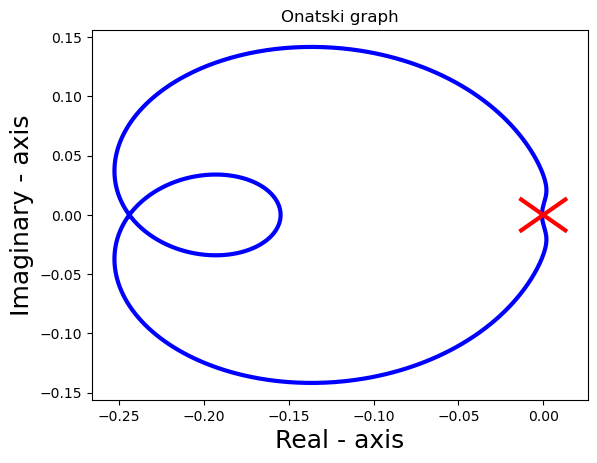

In [6]:
T = 300

exogenous = ['Realshock']

unknowns = ['piL','B']

targets = ['asset_mkt','budget','capital','bonds']

H_U = ha.jacobian(ss, unknowns, targets, T=T)
            
H_Z = ha.jacobian(ss, exogenous, targets, T=T)

targets = ['asset_mkt','budget']

onatski, dU = ld.onatski(targets = targets, endogenous = unknowns,  predetermined=[0, 1], lags=[1, 0] , T =T, ss0=ss0, H_U = H_U,  exogenous = 'Realshock', H_Z = H_Z)

windingNumber = ld.onatskiWindingNumber(onatski)
print(ld.checkSolutions(windingNumber))

ld.plot(onatski)
